In [1]:
#Python-related imports
from datetime import datetime

#PyData imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

#Torch-related imports
import torch
import torch.distributions as D
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function

In [2]:
# Hack to import from a parent directory
import sys
path = '..'
if path not in sys.path:
    sys.path.append(path)
    
from TruncatedNormal import *
from obs_and_flow import LowerBound

In [3]:
torch.manual_seed(0)
np.random.seed(0)

torch.set_printoptions(precision = 8)

In [4]:
temp_ref = 283
temp_rise = 5 #High estimate of 5 celsius temperature rise by 2100.

prior_scale_factor = 0.333

#Parameter prior means
u_M_mean = 0.0016
a_SD_mean = 0.5
a_DS_mean = 0.5
a_M_mean = 0.5
a_MSC_mean = 0.5
k_S_ref_mean = 0.0005
k_D_ref_mean = 0.0008
k_M_ref_mean = 0.0007
Ea_S_mean = 55
Ea_D_mean = 48
Ea_M_mean = 48
c_SOC_mean = 0.5
c_DOC_mean = 0.01
c_MBC_mean = 0.01

#SCON theta truncated normal distribution parameter details in order of mean, sdev, lower, and upper.
u_M_details = torch.Tensor([u_M_mean, u_M_mean * prior_scale_factor, 0, 1])
a_SD_details = torch.Tensor([a_SD_mean, a_SD_mean * prior_scale_factor, 0, 1])
a_DS_details = torch.Tensor([a_DS_mean, a_DS_mean * prior_scale_factor, 0, 1])
a_M_details = torch.Tensor([a_M_mean, a_M_mean * prior_scale_factor, 0, 1])
a_MSC_details = torch.Tensor([a_MSC_mean, a_MSC_mean * prior_scale_factor, 0, 1])
k_S_ref_details = torch.Tensor([k_S_ref_mean, k_S_ref_mean * prior_scale_factor, 0, 1])
k_D_ref_details = torch.Tensor([k_D_ref_mean, k_D_ref_mean * prior_scale_factor, 0, 1])
k_M_ref_details = torch.Tensor([k_M_ref_mean, k_M_ref_mean * prior_scale_factor, 0, 1])
Ea_S_details = torch.Tensor([Ea_S_mean, Ea_S_mean * prior_scale_factor, 10, 100])
Ea_D_details = torch.Tensor([Ea_D_mean, Ea_D_mean * prior_scale_factor, 10, 100])
Ea_M_details = torch.Tensor([Ea_M_mean, Ea_M_mean * prior_scale_factor, 10, 100])

#SCON-C diffusion matrix parameter distribution details
c_SOC_details = torch.Tensor([c_SOC_mean, c_SOC_mean * prior_scale_factor, 0, 1])
c_DOC_details = torch.Tensor([c_DOC_mean, c_DOC_mean * prior_scale_factor, 0, 1])
c_MBC_details = torch.Tensor([c_MBC_mean, c_MBC_mean * prior_scale_factor, 0, 1])

#SCON-C theta rsample draws
u_M = TruncatedNormal(loc = u_M_details[0], scale = u_M_details[1], a = u_M_details[2], b = u_M_details[3]).rsample().cpu().detach().numpy()
a_SD = TruncatedNormal(loc = a_SD_details[0], scale = a_SD_details[1], a = a_SD_details[2], b = a_SD_details[3]).rsample().cpu().detach().numpy()
a_DS = TruncatedNormal(loc = a_DS_details[0], scale = a_DS_details[1], a = a_DS_details[2], b = a_DS_details[3]).rsample().cpu().detach().numpy()
a_M = TruncatedNormal(loc = a_M_details[0], scale = a_M_details[1], a = a_M_details[2], b = a_M_details[3]).rsample().cpu().detach().numpy()
a_MSC = TruncatedNormal(loc = a_MSC_details[0], scale = a_MSC_details[1], a = a_MSC_details[2], b = a_MSC_details[3]).rsample().cpu().detach().numpy()
k_S_ref = TruncatedNormal(loc = k_S_ref_details[0], scale = k_S_ref_details[1], a = k_S_ref_details[2], b = k_S_ref_details[3]).rsample().cpu().detach().numpy()
k_D_ref = TruncatedNormal(loc = k_D_ref_details[0], scale = k_D_ref_details[1], a = k_D_ref_details[2], b = k_D_ref_details[3]).rsample().cpu().detach().numpy()
k_M_ref = TruncatedNormal(loc = k_M_ref_details[0], scale = k_M_ref_details[1], a = k_M_ref_details[2], b = k_M_ref_details[3]).rsample().cpu().detach().numpy()
Ea_S = TruncatedNormal(loc = Ea_S_details[0], scale = Ea_S_details[1], a = Ea_S_details[2], b = Ea_S_details[3]).rsample().cpu().detach().numpy()
Ea_D = TruncatedNormal(loc = Ea_D_details[0], scale = Ea_D_details[1], a = Ea_D_details[2], b = Ea_D_details[3]).rsample().cpu().detach().numpy()
Ea_M = TruncatedNormal(loc = Ea_M_details[0], scale = Ea_M_details[1], a = Ea_M_details[2], b = Ea_M_details[3]).rsample().cpu().detach().numpy()
c_SOC = TruncatedNormal(loc = c_SOC_details[0], scale = c_SOC_details[1], a = c_SOC_details[2], b = c_SOC_details[3]).rsample().cpu().detach().numpy()
c_DOC = TruncatedNormal(loc = c_DOC_details[0], scale = c_DOC_details[1], a = c_DOC_details[2], b = c_DOC_details[3]).rsample().cpu().detach().numpy()
c_MBC = TruncatedNormal(loc = c_MBC_details[0], scale = c_MBC_details[1], a = c_MBC_details[2], b = c_MBC_details[3]).rsample().cpu().detach().numpy()

In [5]:
SCON_C_priors_dict = {'u_M': u_M_details, 'a_SD': a_SD_details, 'a_DS': a_DS_details, 'a_M': a_M_details, 'a_MSC': a_MSC_details, 'k_S_ref': k_S_ref_details, 'k_D_ref': k_D_ref_details, 'k_M_ref': k_M_ref_details, 'Ea_S': Ea_S_details, 'Ea_D': Ea_D_details, 'Ea_M': Ea_M_details, 'c_SOC': c_SOC_details, 'c_DOC': c_DOC_details, 'c_MBC': c_MBC_details}
SCON_C_params_dict = {'u_M': u_M, 'a_SD': a_SD, 'a_DS': a_DS, 'a_M': a_M, 'a_MSC': a_MSC, 'k_S_ref': k_S_ref, 'k_D_ref': k_D_ref, 'k_M_ref': k_M_ref, 'Ea_S': Ea_S, 'Ea_D': Ea_D, 'Ea_M': Ea_M, 'c_SOC': c_SOC, 'c_DOC': c_DOC, 'c_MBC': c_MBC}
print(SCON_C_params_dict)

{'u_M': array(0.0015959, dtype=float32), 'a_SD': array(0.62165385, dtype=float32), 'a_DS': array(0.2763305, dtype=float32), 'a_M': array(0.31480956, dtype=float32), 'a_MSC': array(0.4164662, dtype=float32), 'k_S_ref': array(0.00055727, dtype=float32), 'k_D_ref': array(0.00079384, dtype=float32), 'k_M_ref': array(0.00099425, dtype=float32), 'Ea_S': array(52.987427, dtype=float32), 'Ea_D': array(53.522915, dtype=float32), 'Ea_M': array(42.029236, dtype=float32), 'c_SOC': array(0.4586705, dtype=float32), 'c_DOC': array(0.00339356, dtype=float32), 'c_MBC': array(0.00682223, dtype=float32)}


In [6]:
test_trunc = TruncatedNormal(loc = u_M_details[0], scale = u_M_details[1], a = u_M_details[2], b = u_M_details[3])

print(test_trunc.log_prob(0.0001))
print(test_trunc.log_prob(0.001))
print(test_trunc.log_prob(0.009))

tensor(2.65676308)
tensor(5.98568344)
tensor(-89.83084869)


In [7]:
test_trunc._mean

tensor(0.00160234)

In [8]:
def temp_func(t, TEMP_REF, TEMP_RISE):
    temp = TEMP_REF + (TEMP_RISE * t) / (80 * 24 * 365) + 10 * np.sin((2 * np.pi / 24) * t) + 10 * np.sin((2 * np.pi / (24 * 365)) * t)
    return temp

def I_S_func(t):
    return 0.001 + 0.0005 * np.sin((2 * np.pi / (24 * 365)) * t) #Exogenous SOC input function

def I_D_func(t):
    return 0.0001 + 0.00005 * np.sin((2 * np.pi / (24 * 365)) * t) #Exogenous DOC input function

def arrhenius_temp(parameter, temp, Ea, temp_ref):
    '''
    For a parameter with Arrhenius temperature dependence, returns the transformed parameter value.
    0.008314 is the gas constant. Temperatures are in K.
    '''
    decayed_parameter = parameter * np.exp(-Ea / 0.008314 * (1 / temp - 1 / temp_ref))
    return decayed_parameter

def linear_temp(parameter, temp, Q, temp_ref):
    '''
    For a parameter with linear temperature dependence, returns the transformed parameter value.
    Q is the slope of the temperature dependence and is a varying parameter.
    Temperatures are in K.
    '''
    modified_parameter = parameter - Q * (temp - temp_ref)
    return modified_parameter

In [9]:
#Generate data from SBM SDEs
#x in order of SOC, DOC, MBC (and EEC for AWB family models)

def alpha_SCON(x, SCON_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Force temperature-dependent parameters.
    k_S = arrhenius_temp(SCON_params_dict['k_S_ref'], current_temp, SCON_params_dict['Ea_S'], temp_ref)
    k_D = arrhenius_temp(SCON_params_dict['k_D_ref'], current_temp, SCON_params_dict['Ea_D'], temp_ref)
    k_M = arrhenius_temp(SCON_params_dict['k_M_ref'], current_temp, SCON_params_dict['Ea_M'], temp_ref)
    #Evolve drift.
    SOC = I_S + SCON_params_dict['a_DS'] * k_D * x[1] + SCON_params_dict['a_M'] * SCON_params_dict['a_MSC'] * k_M * x[2] - k_S * x[0]
    DOC = I_D + SCON_params_dict['a_SD'] * k_S * x[0] + SCON_params_dict['a_M'] * (1 - SCON_params_dict['a_MSC']) * k_M * x[2] - (SCON_params_dict['u_M'] + k_D) * x[1]
    MBC = SCON_params_dict['u_M'] * x[1] - k_M * x[2]
    return np.array([SOC, DOC, MBC])

def beta_SCON_C(x, SCON_C_params_dict):
    b11 = SCON_C_params_dict['c_SOC']
    b22 = SCON_C_params_dict['c_DOC']
    b33 = SCON_C_params_dict['c_MBC']
    return np.diag([b11, b22, b33])

def beta_SCON_SS(x, SCON_SS_params_dict):
    b11 = SCON_SS_params_dict['s_SOC'] * x[0]
    b22 = SCON_SS_params_dict['s_DOC'] * x[1]
    b33 = SCON_SS_params_dict['s_MBC'] * x[2]
    return np.diag([b11, b22, b33])

def alpha_SAWB(x, SAWB_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Force temperature-dependent parameters.
    u_Q = linear_temp(SAWB_params_dict['u_Q_ref'], current_temp, SAWB_params_dict['Q'], temp_ref)
    V_D = arrhenius_temp(SAWB_params_dict['V_D_ref'], current_temp, SAWB_params_dict['Ea_V_D'], temp_ref)
    V_U = arrhenius_temp(SAWB_params_dict['V_U_ref'], current_temp, SAWB_params_dict['Ea_V_U'], temp_ref)
    #Evolve drift.
    SOC = I_S + SAWB_params_dict['a_MSA'] * SAWB_params_dict['r_M'] * x[2] - ((V_D * x[3] * x[0]) / (SAWB_params_dict['K_D'] + x[0]))
    DOC = I_D + (1 - SAWB_params_dict['a_MSA']) * SAWB_params_dict['r_M'] * x[2] + ((V_D * x[3] * x[0]) / (SAWB_params_dict['K_D'] + x[0])) + SAWB_params_dict['r_L'] * x[3] - ((V_U * x[2] * x[1]) / (SAWB_params_dict['K_U'] + x[1]))
    MBC = (u_Q * (V_U * x[2] * x[1]) / (SAWB_params_dict['K_U'] + x[1])) - (SAWB_params_dict['r_M'] + SAWB_params_dict['r_E']) * x[2]
    EEC = SAWB_params_dict['r_E'] * x[2] - SAWB_params_dict['r_L'] * x[3]
    return np.array([SOC, DOC, MBC, EEC])

def beta_SAWB_C(x, SAWB_C_params_dict):
    b11 = SAWB_C_params_dict['c_SOC']
    b22 = SAWB_C_params_dict['c_DOC']
    b33 = SAWB_C_params_dict['c_MBC']
    b44 = SAWB_C_params_dict['c_EEC']
    return np.diag([b11, b22, b33, b44])

def beta_SAWB_SS(x, SAWB_SS_params_dict):
    b11 = SAWB_SS_params_dict['s_SOC'] * x[0]
    b22 = SAWB_SS_params_dict['s_DOC'] * x[1]
    b33 = SAWB_SS_params_dict['s_MBC'] * x[2]
    b44 = SAWB_SS_params_dict['s_EEC'] * x[3]
    return np.diag([b11, b22, b33, b44])

def alpha_SAWB_ECA(x, SAWB_ECA_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Force temperature-dependent parameters.
    u_Q = linear_temp(SAWB_ECA_params_dict['u_Q_ref'], current_temp, SAWB_ECA_params_dict['Q'], temp_ref)
    V_DE = arrhenius_temp(SAWB_ECA_params_dict['V_DE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_DE'], temp_ref)
    V_UE = arrhenius_temp(SAWB_ECA_params_dict['V_UE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_UE'], temp_ref)
    #Evolve drift.
    SOC = I_S + SAWB_ECA_params_dict['a_MSA'] * SAWB_ECA_params_dict['r_M'] * x[2] - ((V_DE * x[3] * x[0]) / (SAWB_ECA_params_dict['K_DE'] + x[3] + x[0]))
    DOC = I_D + (1 - SAWB_ECA_params_dict['a_MSA']) * SAWB_ECA_params_dict['r_M'] * x[2] + ((V_DE * x[3] * x[0]) / (SAWB_ECA_params_dict['K_DE'] + x[3] + x[0])) + SAWB_ECA_params_dict['r_L'] * x[3] - ((V_UE * x[2] * x[1]) / (SAWB_ECA_params_dict['K_UE'] + x[2] + x[1]))
    MBC = (u_Q * (V_UE * x[2] * x[1]) / (SAWB_ECA_params_dict['K_UE'] + x[2] + x[1])) - (SAWB_ECA_params_dict['r_M'] + SAWB_ECA_params_dict['r_E']) * x[2]
    EEC = SAWB_ECA_params_dict['r_E'] * x[2] - SAWB_ECA_params_dict['r_L'] * x[3]
    return np.array([SOC, DOC, MBC, EEC])

def beta_SAWB_ECA_C(x, SAWB_ECA_C_params_dict):
    b11 = SAWB_ECA_C_params_dict['c_SOC']
    b22 = SAWB_ECA_C_params_dict['c_DOC']
    b33 = SAWB_ECA_C_params_dict['c_MBC']
    b44 = SAWB_ECA_C_params_dict['c_EEC']
    return np.diag([b11, b22, b33, b44])

def beta_SAWB_ECA_SS(x, SAWB_ECA_SS_params_dict):
    b11 = SAWB_ECA_SS_params_dict['s_SOC'] * x[0]
    b22 = SAWB_ECA_SS_params_dict['s_DOC'] * x[1]
    b33 = SAWB_ECA_SS_params_dict['s_MBC'] * x[2]
    b44 = SAWB_ECA_SS_params_dict['s_EEC'] * x[3]
    return np.diag([b11, b22, b33, b44])

In [10]:
def get_CO2_CON_gen_y(x, SCON_params_dict, current_temp, TEMP_REF):
    state_dim = 3 #SCON has three state variables in SOC, DOC, and MBC.
    SOC, DOC, MBC =  np.array_split(x, state_dim, 0) #Partition SOC, DOC, and MBC values. Split based on final C_PATH dim, which specifies state variables and is also indexed as dim #2 in tensor.
    #Decay parameters are forced by temperature changes.    
    k_S = arrhenius_temp(SCON_params_dict['k_S_ref'], current_temp, SCON_params_dict['Ea_S'], TEMP_REF) #Apply vectorized temperature-dependent transformation to k_S_ref.
    k_D = arrhenius_temp(SCON_params_dict['k_D_ref'], current_temp, SCON_params_dict['Ea_D'], TEMP_REF) #Apply vectorized temperature-dependent transformation to k_D_ref.
    k_M = arrhenius_temp(SCON_params_dict['k_M_ref'], current_temp, SCON_params_dict['Ea_M'], TEMP_REF) #Apply vectorized temperature-dependent transformation to k_M_ref.
    CO2 = (k_S * SOC * (1 - SCON_params_dict['a_SD'])) + (k_D * DOC * (1 - SCON_params_dict['a_DS'])) + (k_M * MBC * (1 - SCON_params_dict['a_M']))
    return np.amax(CO2, 0)

def get_CO2_AWB_gen_y(x, SAWB_params_dict, current_temp, TEMP_REF):
    state_dim = 4 #SAWB and SAWB-ECA have four state variables in SOC, DOC, MBC, and EEC.
    SOC, DOC, MBC, EEC = np.array_split(x, state_dim, 0) #Partition SOC, DOC, MBC, EEC values. Split based on final C_PATH dim, which specifies state variables and is also indexed as dim #2 in tensor. 
    #Decay parameters are forced by temperature changes.    
    u_Q = linear_temp(SAWB_params_dict['u_Q_ref'], current_temp, SAWB_params_dict['Q'], TEMP_REF) #Apply linear temperature-dependence to u_Q.
    V_D = arrhenius_temp(SAWB_params_dict['V_D_ref'], current_temp, SAWB_params_dict['Ea_V_D'], TEMP_REF) #Apply vectorized temperature-dependent transformation to V_D.
    V_U = arrhenius_temp(SAWB_params_dict['V_U_ref'], current_temp, SAWB_params_dict['Ea_V_U'], TEMP_REF) #Apply vectorized temperature-dependent transformation to V_U.
    CO2 = (1 - u_Q) * (V_U * MBC * DOC) / (SAWB_params_dict['K_U'] + MBC + DOC)
    return np.amax(CO2, 0)

def get_CO2_AWB_ECA_gen_y(x, SAWB_ECA_params_dict, current_temp, TEMP_REF):
    state_dim = 4 #SAWB and SAWB-ECA have four state variables in SOC, DOC, MBC, and EEC.
    SOC, DOC, MBC, EEC = np.array_split(x, state_dim, 0) #Partition SOC, DOC, MBC, EEC values. Split based on final C_PATH dim, which specifies state variables and is also indexed as dim #2 in tensor. 
    #Decay parameters are forced by temperature changes.    
    u_Q = linear_temp(SAWB_ECA_params_dict['u_Q_ref'], current_temp, SAWB_ECA_params_dict['Q'], TEMP_REF) #Apply linear temperature-dependence to u_Q.
    V_DE = arrhenius_temp(SAWB_ECA_params_dict['V_DE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_DE'], TEMP_REF) #Apply vectorized temperature-dependent transformation to V_DE.
    V_UE = arrhenius_temp(SAWB_ECA_params_dict['V_UE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_UE'], TEMP_REF) #Apply vectorized temperature-dependent transformation to V_UE.
    CO2 = (1 - u_Q) * (V_UE * MBC * DOC) / (SAWB_ECA_params_dict['K_UE'] + MBC + DOC)
    return np.amax(CO2, 0)

In [11]:
def get_SBM_SDE_euler_maruyama_y(ALPHA, BETA, X0, T, DT, THETA_DICT, I_S_FUNC, I_D_FUNC, TEMP_FUNC, TEMP_REF, TEMP_RISE, OBS_EVERY, OBS_ERROR_SCALE, lower_bound = 1e-4):
    state_dim = 0
    get_CO2_gen_y = None
    if ALPHA == alpha_SCON:
        state_dim = 3
        get_CO2_gen_y = get_CO2_CON_gen_y
    elif ALPHA == alpha_SAWB:
        state_dim = 4
        get_CO2_gen_y = get_CO2_AWB_gen_y
    elif ALPHA == alpha_SAWB_ECA:
        state_dim = 4
        get_CO2_gen_y = get_CO2_AWB_ECA_gen_y
    N = int(T / DT) + 1
    M = int(T / OBS_EVERY) + 1
    x = np.zeros([state_dim, N])
    CO2 = np.zeros([1, N])
    X0_array = np.array(X0)
    X0_sample = np.random.normal(loc = X0_array, scale = OBS_ERROR_SCALE * X0_array) #Add noise to initial conditions of x.
    X0_sample[X0_sample < lower_bound] = lower_bound #Bound initial conditions above 0. 
    print('X0_sample = ', X0_sample)
    x[:, 0] = X0_sample
    CO2[:, 0] = get_CO2_gen_y(x[:, 0], THETA_DICT, TEMP_FUNC(0, TEMP_REF, TEMP_RISE), TEMP_REF)
    hour = 0
    for i in range(1, N):
        hour += DT
        I_S = I_S_FUNC(hour)
        #print('I_S', I_S)
        I_D = I_D_FUNC(hour)
        #print('I_D', I_D)
        current_temp = TEMP_FUNC(hour, TEMP_REF, TEMP_RISE)
        #print('current_temp', current_temp)
        #Take Euler-Maruyama step. Note: np.random.normal takes std while np.random.multivariate_normal takes cov.
        x[:, i] = np.random.multivariate_normal(mean = x[:, i - 1] + ALPHA(x[:, i - 1], THETA_DICT, I_S, I_D, current_temp, TEMP_REF, arrhenius_temp, linear_temp) * DT, cov = BETA(x[:, i - 1], THETA_DICT) * DT)
        x[:, i][x[:, i] < lower_bound] = lower_bound #Bound all x above 0.
        #print('x at i', x[:, i])
        CO2[:, i] = get_CO2_gen_y(x[:, i], THETA_DICT, current_temp, TEMP_REF) #Compute CO2.
    x_with_CO2 = np.concatenate((x, CO2), 0)
    x_with_CO2_for_y = x_with_CO2[:, 0::int(OBS_EVERY / DT)] #Slice x based on observation interval to generate y.
    obs_var_scale = OBS_ERROR_SCALE * x_with_CO2_for_y.mean(1)
    y = x_with_CO2_for_y + obs_var_scale[:, np.newaxis] * np.random.normal(loc = 0, scale = 1, size = x_with_CO2_for_y.shape) #Introduce observation error based on mean state sizes to generate y.
    y[y < lower_bound] = lower_bound #Bound all y above 0.
    return {'y': y, 't_y': np.arange(0, T + DT, OBS_EVERY), 'y_std': obs_var_scale, 'x': x_with_CO2, 't_x': np.arange(0, T + DT, DT)}

def get_SBM_SDE_euler_maruyama_y_det(ALPHA, X0, T, DT, THETA_DICT, I_S_FUNC, I_D_FUNC, TEMP_FUNC, TEMP_REF, TEMP_RISE, OBS_EVERY, OBS_ERROR_SCALE, lower_bound = 1e-4):
    state_dim = 0
    get_CO2_gen_y = None
    if ALPHA == alpha_SCON:
        state_dim = 3
        get_CO2_gen_y = get_CO2_CON_gen_y
    elif ALPHA == alpha_SAWB:
        state_dim = 4
        get_CO2_gen_y = get_CO2_AWB_gen_y
    elif ALPHA == alpha_SAWB_ECA:
        state_dim = 4
        get_CO2_gen_y = get_CO2_AWB_ECA_gen_y
    N = int(T / DT) + 1
    M = int(T / OBS_EVERY) + 1
    x = np.zeros([state_dim, N])
    CO2 = np.zeros([1, N])
    X0_array = np.array(X0)
    X0_sample = np.random.normal(loc = X0_array, scale = OBS_ERROR_SCALE * X0_array) #Add noise to initial conditions of x.
    X0_sample[X0_sample < lower_bound] = lower_bound #Bound initial conditions above 0. 
    print('X0_sample = ', X0_sample)
    x[:, 0] = X0_sample
    CO2[:, 0] = get_CO2_gen_y(x[:, 0], THETA_DICT, TEMP_FUNC(0, TEMP_REF, TEMP_RISE), TEMP_REF) #Compute initial CO2.
    hour = 0
    for i in range(1, N):
        hour += DT
        I_S = I_S_FUNC(hour)
        #print('I_S', I_S)
        I_D = I_D_FUNC(hour)
        #print('I_D', I_D)
        current_temp = TEMP_FUNC(hour, TEMP_REF, TEMP_RISE)
        #print('current_temp', current_temp)
        #Take Euler.
        x[:, i] = x[:, i - 1] + ALPHA(x[:, i - 1], THETA_DICT, I_S, I_D, current_temp, TEMP_REF, arrhenius_temp, linear_temp) * DT
        x[:, i][x[:, i] < lower_bound] = lower_bound #Bound all x above 0.
        #print('x at i', x[:, i])
        CO2[:, i] = get_CO2_gen_y(x[:, i], THETA_DICT, current_temp, TEMP_REF) #Compute CO2. 
    x_with_CO2 = np.concatenate((x, CO2), 0)
    x_with_CO2_for_y = x_with_CO2[:, 0::int(OBS_EVERY / DT)] #Slice x based on observation interval to generate y.
    obs_var_scale = OBS_ERROR_SCALE * x_with_CO2_for_y.mean(1)
    y = x_with_CO2_for_y + obs_var_scale[:, np.newaxis] * np.random.normal(loc = 0, scale = 1, size = x_with_CO2_for_y.shape) #Introduce observation error based on mean state sizes to generate y.
    y[y < lower_bound] = lower_bound #Bound all y above 0.
    return {'y': y, 't_y': np.arange(0, T + DT, OBS_EVERY), 'y_std': obs_var_scale, 'x': x_with_CO2, 't_x': np.arange(0, T + DT, DT)}

In [12]:
dt = 0.01
t = 1000
x0_SCON = [65, 0.4, 2.5]
obs_every = 5
obs_error_scale = 0.1

In [13]:
y_dict = get_SBM_SDE_euler_maruyama_y(alpha_SCON, beta_SCON_C, x0_SCON, t, dt, SCON_C_params_dict, I_S_func, I_D_func, temp_func, temp_ref, temp_rise, obs_every, obs_error_scale)

X0_sample =  [76.46634025  0.41600629  2.7446845 ]


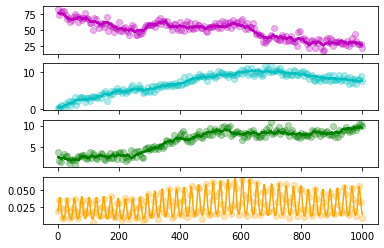

In [14]:
fig, axs = plt.subplots(4, sharex = True)
axs[0].plot(y_dict['t_x'], y_dict['x'][0, :], color = "m", label = 'SOC x')
axs[0].scatter(y_dict['t_y'], y_dict['y'][0, :], color = "m", alpha = 0.3, label = 'SOC y')
axs[1].plot(y_dict['t_x'], y_dict['x'][1, :], color = "c", label = 'DOC x')
axs[1].scatter(y_dict['t_y'], y_dict['y'][1, :], color = "c", alpha = 0.3, label = 'DOC y')
axs[2].plot(y_dict['t_x'], y_dict['x'][2, :], color = "g", label = 'MBC x')
axs[2].scatter(y_dict['t_y'], y_dict['y'][2, :], color = "g", alpha = 0.3, label = 'MBC y')
axs[3].plot(y_dict['t_x'], y_dict['x'][3, :], color = "orange", label = 'CO2')
axs[3].scatter(y_dict['t_y'], y_dict['y'][3, :], color = "orange", alpha = 0.3, label = 'CO2 y')

In [15]:
now = datetime.now()
sbm_model = 'SCON-C_CO2_trunc' + now.strftime('_%Y_%m_%d_%H_%M')
dir_path = '../generated_data/'
save_string = dir_path + f'{sbm_model}_sample_y_t_{t}_dt_{dt}_sd_scale_{prior_scale_factor}'.replace('.','-')
save_string_x = dir_path + f'{sbm_model}_sample_x_t_{t}_dt_{dt}_sd_scale_{prior_scale_factor}'.replace('.','-')
fig.savefig(save_string + '.png', dpi = 300)

In [16]:
#Save CSV of stochastic path.
df_y = pd.DataFrame(data = {'hour': y_dict['t_y'], 'SOC': y_dict['y'][0, :], 'DOC': y_dict['y'][1, :], 'MBC': y_dict['y'][2, :], 'CO2': y_dict['y'][3, :]})
df_y.to_csv(save_string + '.csv', index = False)

In [17]:
#Save CSV of unobserved x.
#df_x = pd.DataFrame(data = {'hour': y_dict['t_x'], 'SOC': y_dict['x'][0, :], 'DOC': y_dict['x'][1, :], 'MBC': y_dict['x'][2, :], 'CO2': y_dict['x'][3, :]})
#df_x.to_csv(save_string_x + '.csv', index = False)

In [17]:
#Save rsampled theta values.
torch.save(SCON_C_params_dict, save_string + '_rsample.pt')

#Save priors dict.
torch.save(SCON_C_priors_dict, save_string + '_hyperparams.pt')

In [18]:
print(df_y)

       hour        SOC       DOC        MBC       CO2
0       0.0  83.732573  0.357230   4.003253  0.019283
1       5.0  74.321574  0.486244   1.866125  0.035494
2      10.0  78.748275  1.187536   1.716889  0.023856
3      15.0  80.129970  0.756197   2.880347  0.008816
4      20.0  79.193884  0.193996   3.462429  0.008784
..      ...        ...       ...        ...       ...
196   980.0  33.655250  6.945214   9.063667  0.012954
197   985.0  28.447518  7.804927   9.610224  0.032066
198   990.0  28.156761  8.229177  10.341631  0.055782
199   995.0  27.984536  9.115186  10.297376  0.032427
200  1000.0  21.965610  7.724955   9.925911  0.008676

[201 rows x 5 columns]


In [19]:
y_det_dict = get_SBM_SDE_euler_maruyama_y_det(alpha_SCON, x0_SCON, t, dt, SCON_C_params_dict, I_S_func, I_D_func, temp_func, temp_ref, temp_rise, obs_every, obs_error_scale)

X0_sample =  [64.77969735  0.40557963  2.63099044]


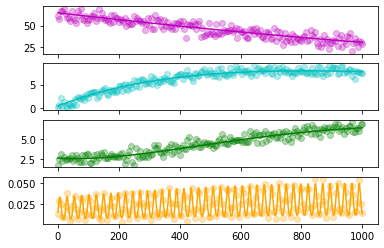

In [20]:
fig2, axs2 = plt.subplots(4, sharex = True)
axs2[0].plot(y_det_dict['t_x'], y_det_dict['x'][0, :], color = "m", label = 'SOC x')
axs2[0].scatter(y_det_dict['t_y'], y_det_dict['y'][0, :], color = "m", alpha = 0.3, label = 'SOC y')
axs2[1].plot(y_det_dict['t_x'], y_det_dict['x'][1, :], color = "c", label = 'DOC x')
axs2[1].scatter(y_det_dict['t_y'], y_det_dict['y'][1, :], color = "c", alpha = 0.3, label = 'DOC y')
axs2[2].plot(y_det_dict['t_x'], y_det_dict['x'][2, :], color = "g", label = 'MBC x')
axs2[2].scatter(y_det_dict['t_y'], y_det_dict['y'][2, :], color = "g", alpha = 0.3, label = 'MBC y')
axs2[3].plot(y_det_dict['t_x'], y_det_dict['x'][3, :], color = "orange", label = 'CO2')
axs2[3].scatter(y_det_dict['t_y'], y_det_dict['y'][3, :], color = "orange", alpha = 0.3, label = 'CO2 y')

In [21]:
save_string_det = dir_path + f'{sbm_model}_sample_det_y_t_{t}_dt_{dt}_sd_scale_{prior_scale_factor}'.replace('.','-')
fig2.savefig(save_string_det + '.png', dpi = 300)

In [ ]:
df_y_det = pd.DataFrame(data = {'hour': y_det_dict['t_y'], 'SOC': y_det_dict['y'][0, :], 'DOC': y_det_dict['y'][1, :], 'MBC': y_det_dict['y'][2, :], 'CO2': y_det_dict['y'][3, :]})
df_y_det.to_csv(save_string_det + '.csv', index = False)

In [ ]:
print(df_y_det)